In [346]:
import lxml.etree as et
import numpy as np
import pandas as pd
from IPython.display import SVG, display

In [267]:
%load_ext autoreload
%autoreload 1
%aimport adastra

reloaded adastra


In [268]:
fa17missing = [
    ('OIE1000', 5/3),  # OIE
    ('AHSE1148', 10/3),  # DIRT TO SHIRT
    ('ENGR3590', 3),  # ADE
    ('AHSE1100', 10/3),  # HISTECH
    ('ENGR3299', 8),  # RETURN DESIGN
]
sp18missing = [
    ('ENGR3590', 10/3),  # CompRobo
    ('ENGR3240', 16/3),  # TELL THE STORY
    ('MTH2132', 10/3),  # BAYESIAN
    ('ENGR3299', 10/3),  # BIOMIMICRY
    ('ENGR3599A', 10/3),  # HTL
    ('ENGR3299B', 8),  # RETURN DESIGN
]
tup_to_dict = lambda a: [{'Course/Customer': code, 'Weekly Length': pd.to_timedelta(hours, unit='h')} for code, hours in a]
fa17missing, sp18missing = tuple(tup_to_dict(l) for l in [fa17missing, sp18missing])

In [269]:
fa17courses = adastra.load_schedule_file('data/ad astra test fa17.xls')
sp18courses = adastra.load_schedule_file('data/ad astra test sp18.xls')

WARNING *** file size (190919) not 512 + multiple of sector size (512)
WARNING *** file size (222207) not 512 + multiple of sector size (512)


In [270]:
add_missing = lambda a, m: pd.concat([a, pd.DataFrame(m)], sort=True, ignore_index=False).reset_index()
fa17courses = add_missing(fa17courses, fa17missing)
sp18courses = add_missing(sp18courses, sp18missing)
fa17courses[-10:]

,index,Activity Type,Building,Campus,Contact/Instructor,Course/Customer,Days,End Date,End Time,Enroll,Length,Room,Section,Start Date,Start Time,Status,Subj/Reservation,Title,Weekly Length
61,492,Section,AC,Olin,"Pratt, Joanne",SCI2215,F,2017-12-08,12:30:00,15.0,02:40:00,417,01,2017-08-31,09:50:00,Scheduled,SCI2,Emerging Technologies in Cancer,02:40:00
62,558,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,T,2017-12-08,15:10:00,24.0,02:10:00,428,01,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
63,559,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,W,2017-12-08,15:10:00,24.0,02:10:00,428,02,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
64,560,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,R,2017-12-08,15:10:00,24.0,02:10:00,428,03,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
65,561,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,F,2017-12-08,15:10:00,24.0,02:10:00,428,04,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
66,0,NaN,NaN,NaN,NaN,OIE1000,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,01:40:00.000001
67,1,NaN,NaN,NaN,NaN,AHSE1148,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
68,2,NaN,NaN,NaN,NaN,ENGR3590,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:00:00
69,3,NaN,NaN,NaN,NaN,AHSE1100,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
70,4,NaN,NaN,NaN,NaN,ENGR3299,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,08:00:00


In [271]:
fa17cat = pd.read_csv('Class and Room Categorization - Classes Fall 2017.csv', usecols=range(13))
fa17cat.drop_duplicates(subset='Course Code', inplace=True)
sp18cat = pd.read_csv('Class and Room Categorization - Classes Spring 2018.csv', usecols=range(13))
sp18cat.drop_duplicates(subset='Course Code', inplace=True)

In [272]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def to_int(text):
    return int(text.strip('" '))

def getEnrollment(filename):
    enrollment = pd.read_csv(
        filename,
        usecols=[2,9],
        converters = {'Crs No' : strip, 'Registered Students' : to_int})
    enrollment.drop_duplicates(subset='Crs No', inplace=True)
    return enrollment

In [273]:
fa17enrollment = getEnrollment('FA17_Enrollment.csv')
sp18enrollment = getEnrollment('SP18_Enrollment.csv')

In [277]:
def merge(sched, enrollment, sched_code='Course/Customer', en_code='Crs No'):

#     def agg_time(frame, group_col, agg_col):
#         return frame.groupby(group_col, as_index=False)[agg_col].agg(np.sum)

    merge1 = pd.merge(
        left=sched,
        right=enrollment,
        how='inner',
        left_on=sched_code,
        right_on=en_code,
        indicator=True,
#         validate='one_to_many'
    )
    
    return merge1
#     return pd.merge(
#         left=merge1,
#         right=enrollment,
#         how='inner',
#         left_on=sched_code,
#         right_on=en_code,
#         indicator='exists'
#     )

agg_by_time = lambda a: a.groupby('Course/Customer', as_index=False)['Weekly Length'].agg(np.sum)
agg_by_room = lambda a: a.groupby('Room', as_index=False)['Weekly Length'].agg(np.sum)

In [315]:
#fa17footprint, sp18footprint = tuple(merge(agg_by_time(sched), enrollment) for sched, enrollment in [(fa17courses, fa17enrollment),(sp18courses, sp18enrollment)])
fa17footprint, sp18footprint = tuple(merge(sched, enrollment) for sched, enrollment in [(fa17courses, fa17enrollment),(sp18courses, sp18enrollment)])
fa17_room_usage = agg_by_room(fa17footprint)
fa17_room_usage.sort_values('Weekly Length', inplace=True)
print(fa17_room_usage)

   Room Weekly Length
1   109      03:20:00
0   104      04:00:00
9   305      05:35:00
12  313      06:40:00
11  309      06:40:00
10  306      06:40:00
2   113      07:00:00
20  428      08:40:00
3   128      10:00:00
6   209      10:20:00
4   204      10:20:00
5   206      10:20:00
18  413      10:40:00
19  417      11:00:00
7   213      12:20:00
16  406      12:20:00
17  409      13:00:00
15  328      13:20:00
8   304      17:15:00
13  318      20:25:00
14  326      22:30:00


In [363]:
filenames = ['1stFloorPoly','2ndFloorPoly', '3rdFloorPoly']

In [334]:
def getPolygonCenter(pts):
    xMax = np.max(pts[:,0])
    xMin = np.min(pts[:,0])
    xC = (xMax - xMin)/2 + xMin
    
    yMax = np.max(pts[:,1])
    yMin = np.min(pts[:,1])
    yC = (yMax - yMin)/2 + yMin
    
    return(np.array([xC, yC]))

def getRecenterString(center, scale):
    c = (1 - scale) * center
    return 'translate(' + str(c[0]) + ', ' + str(c[1]) + ')'

def rescale(data, min, max):
    n = data.max() - data.min()
    return ((data - data.min())/n)*(max - min) + min

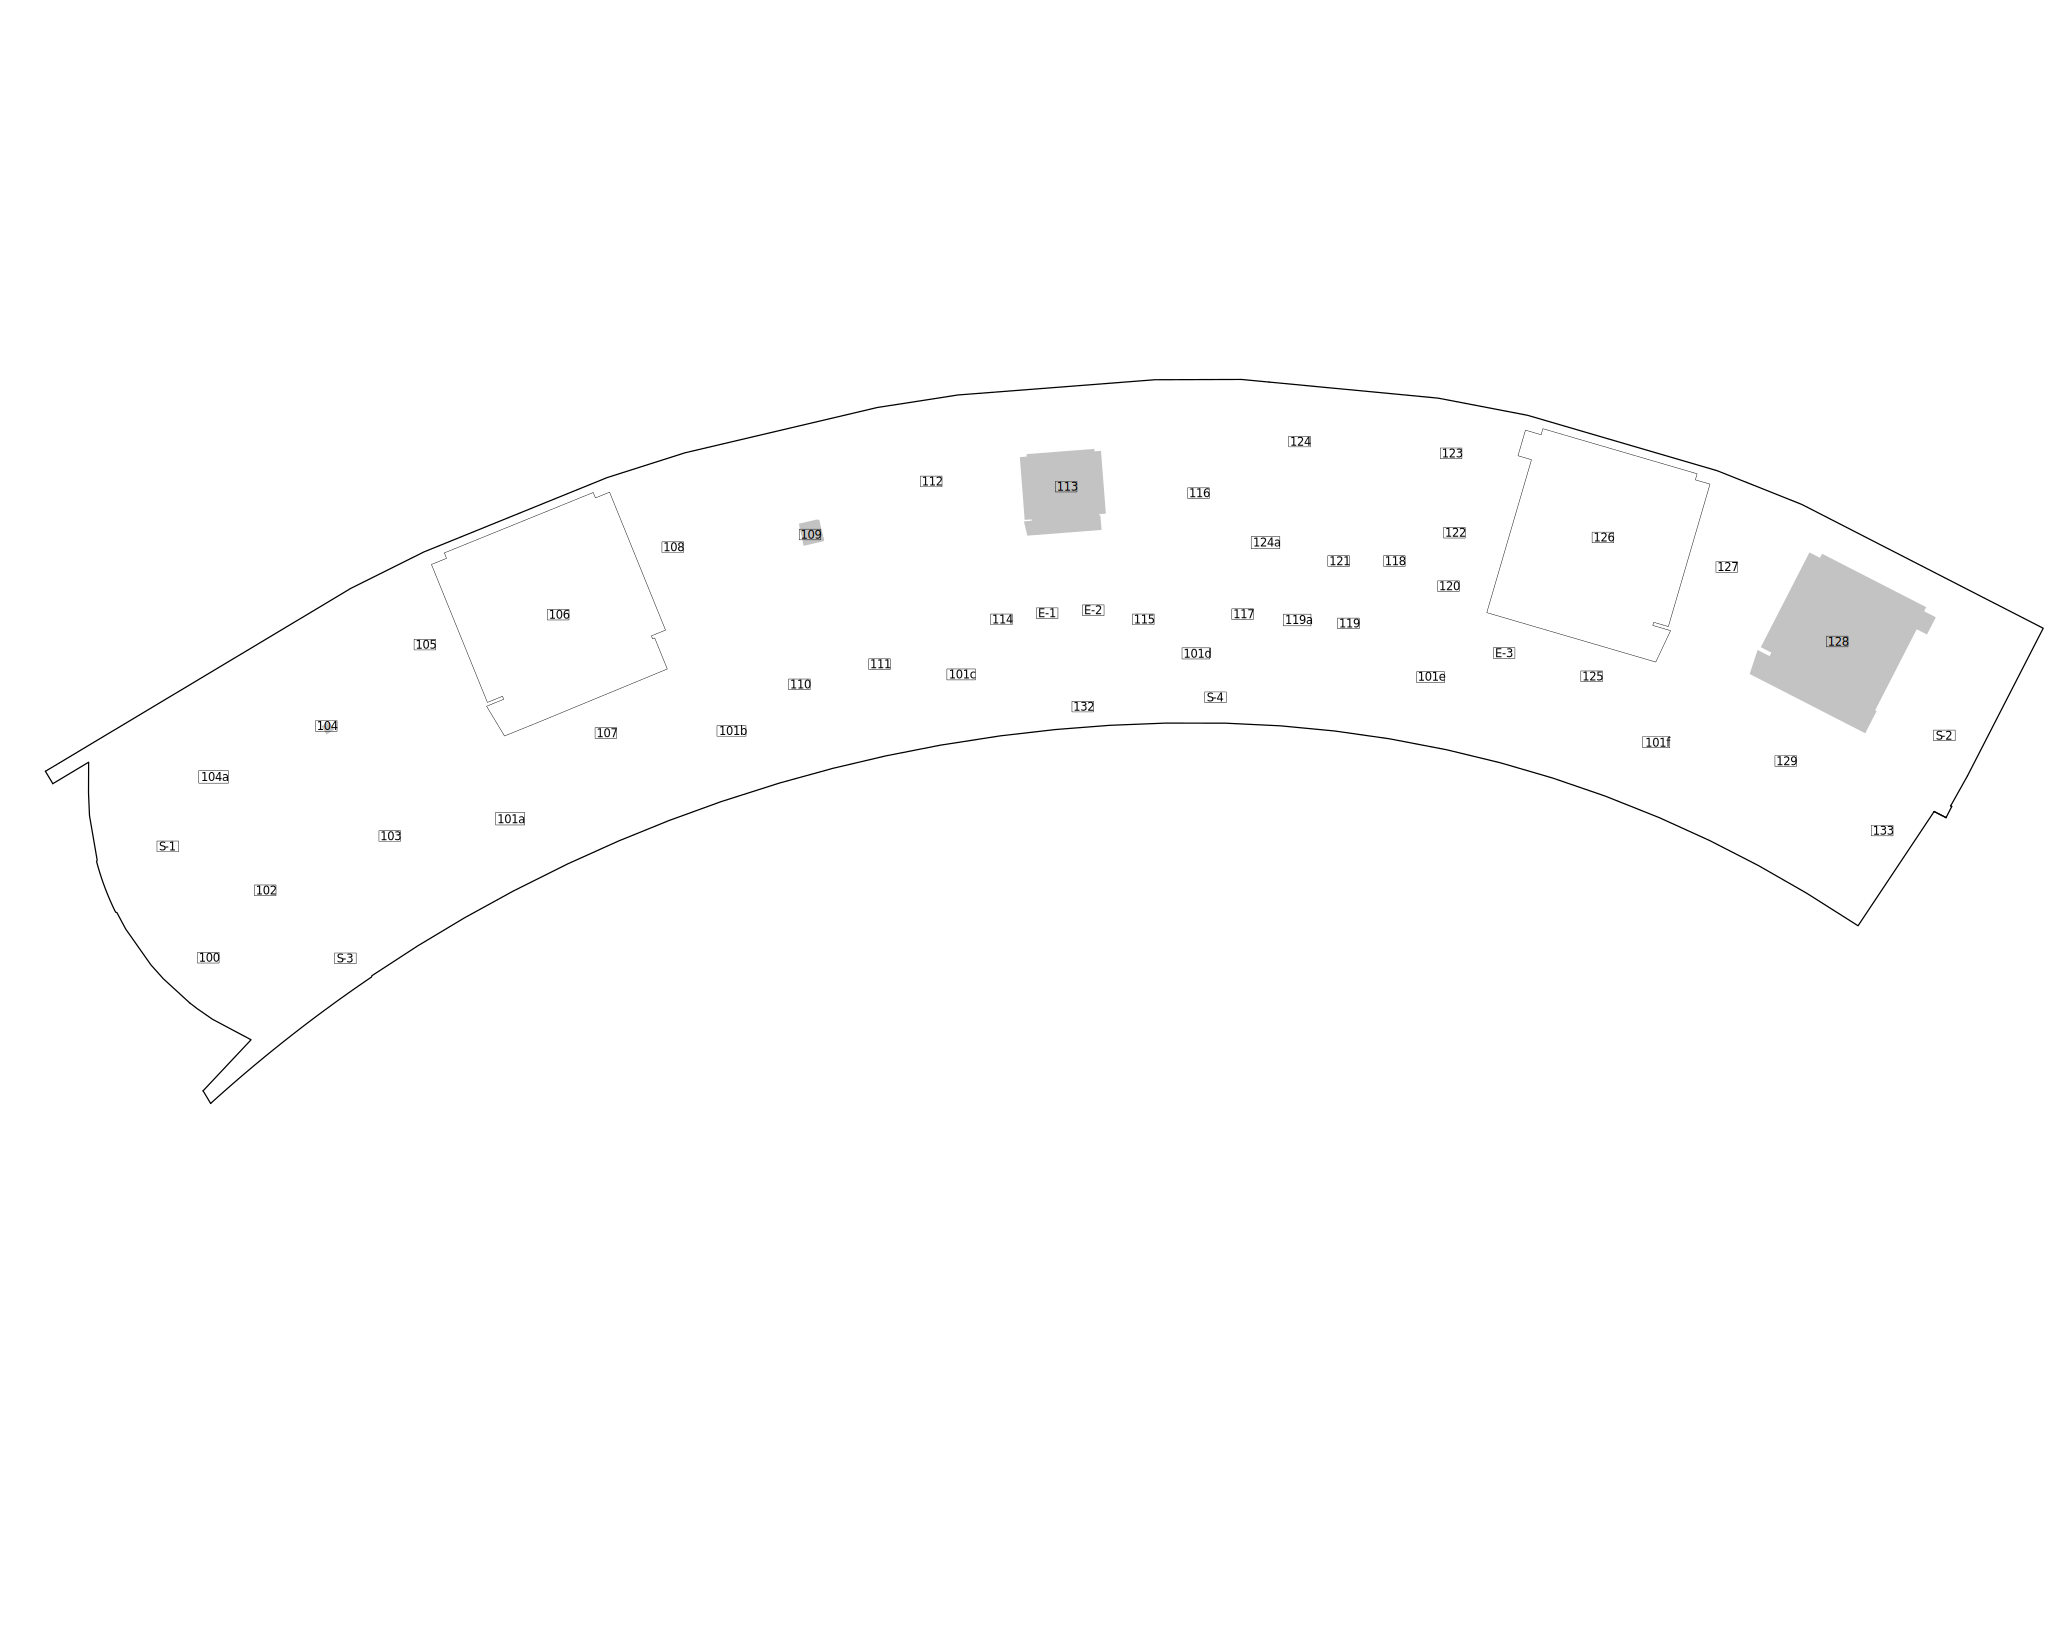

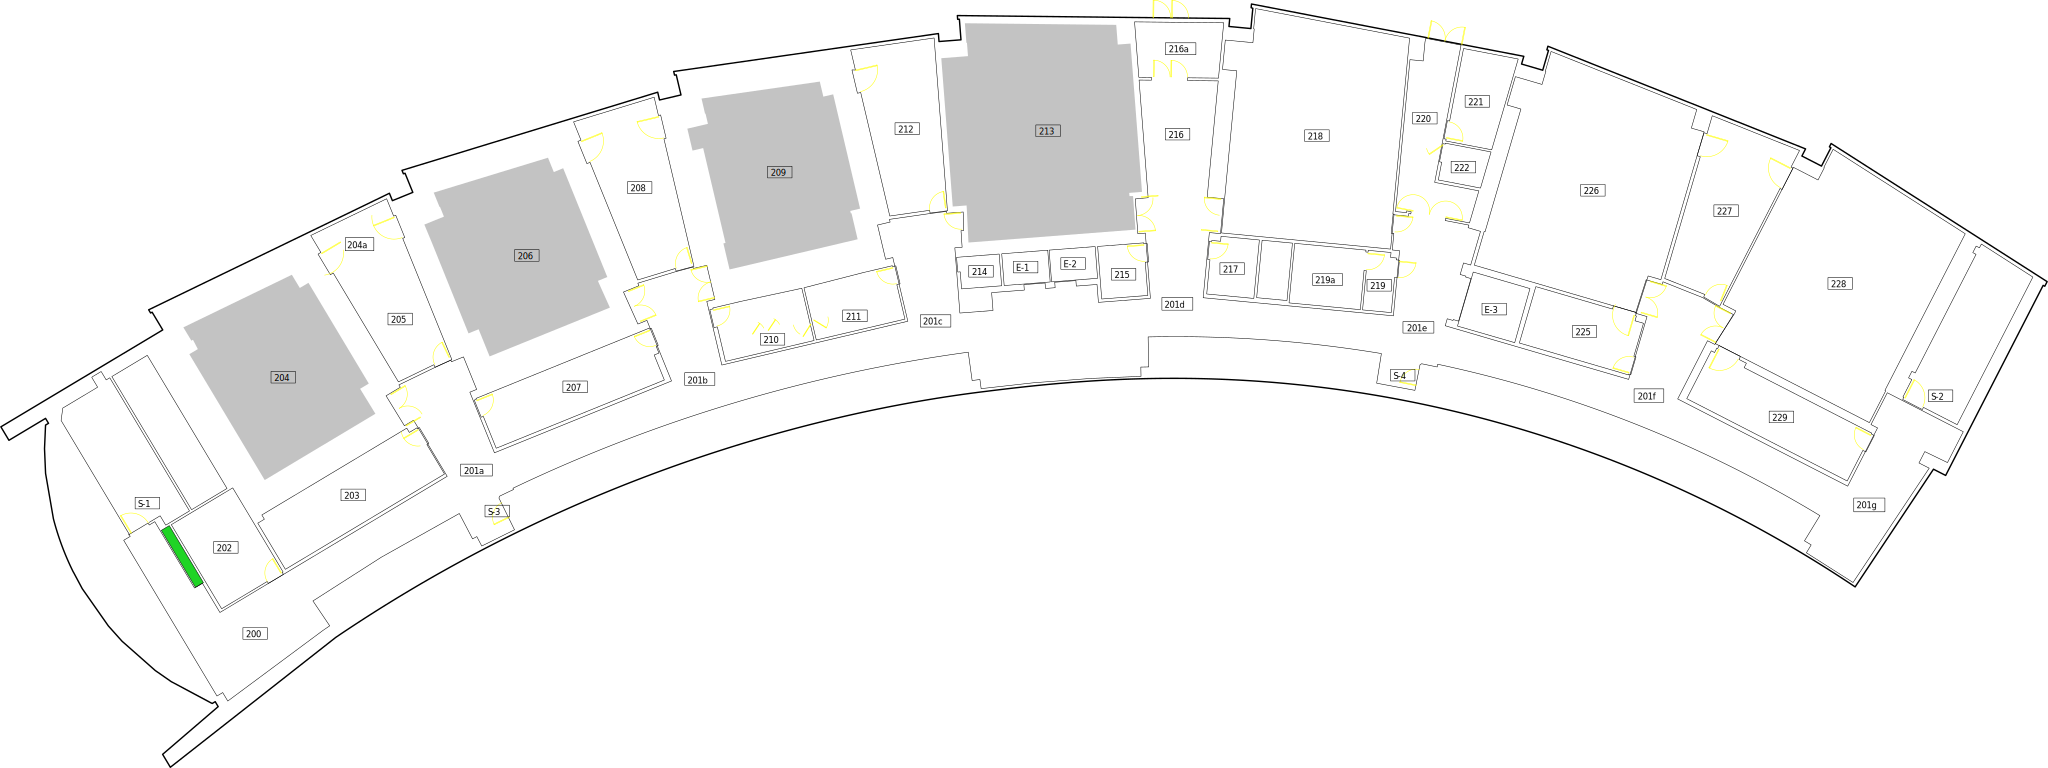

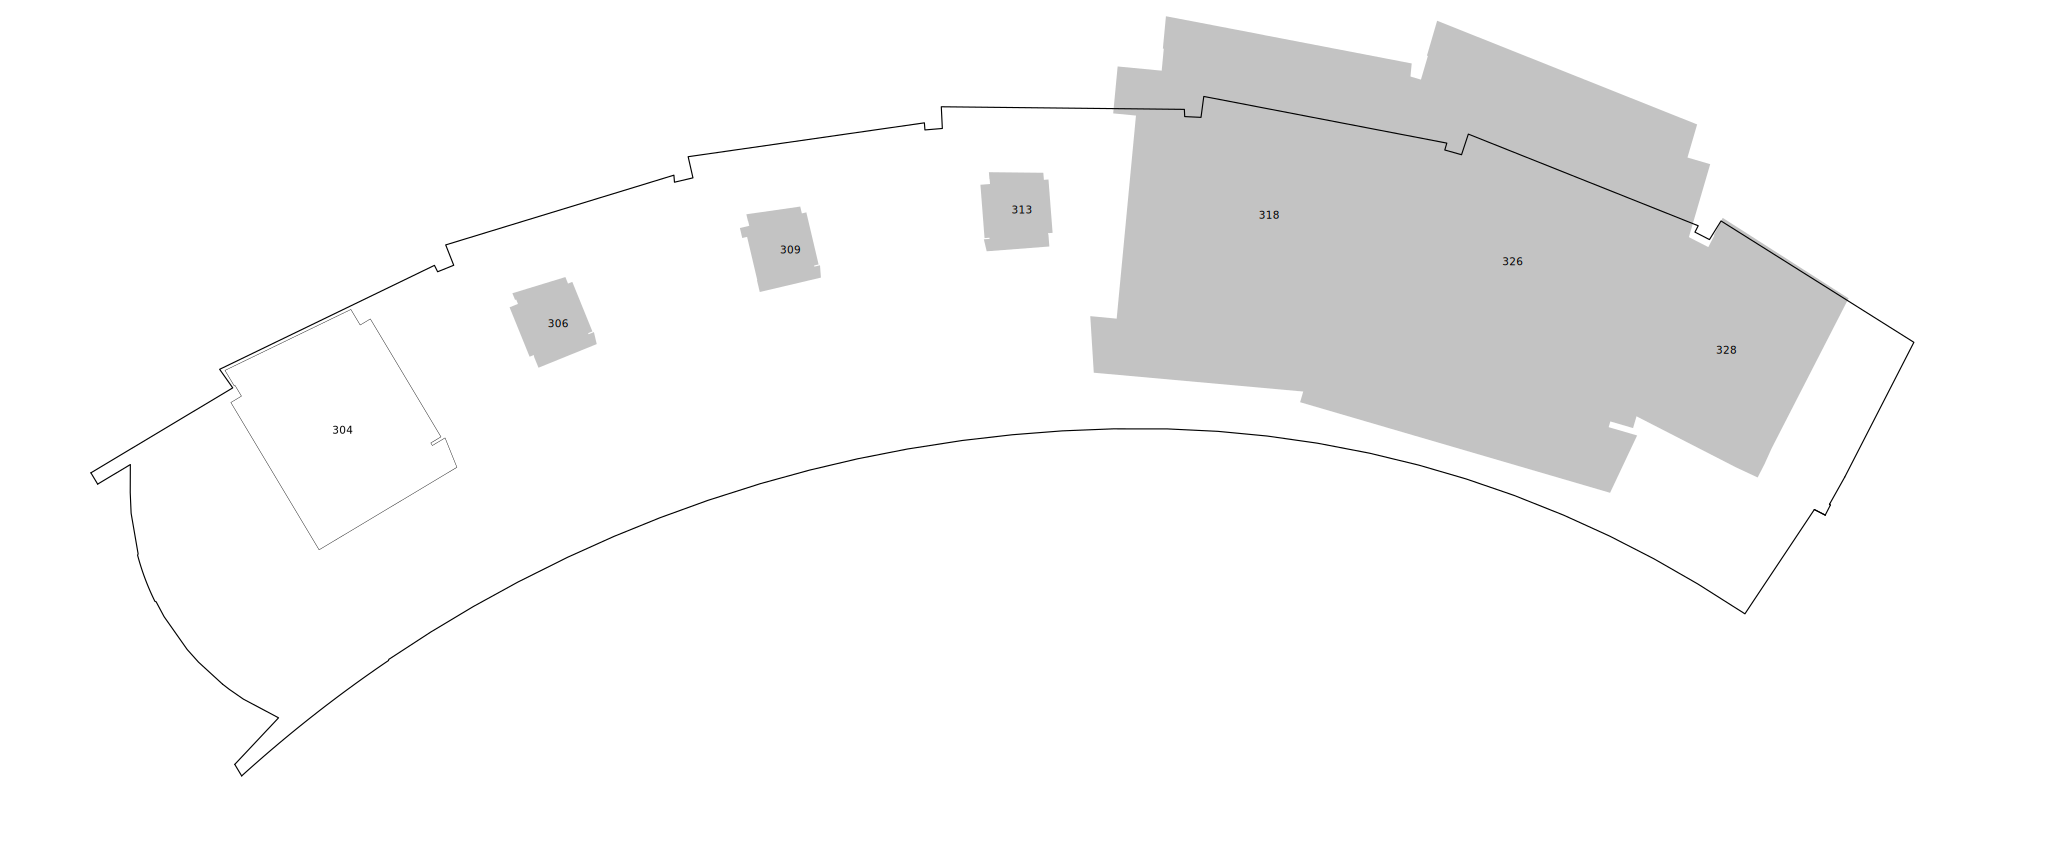

In [365]:
for filename in filenames:
    inFile = './' + filename + '.svg'
    outFile = './' + filename + '_util.svg'
    xml = et.parse(inFile)
    ac2 = xml.getroot()
    traces = ac2.findall('.//{http://www.w3.org/2000/svg}g')[0]
    classroom = traces.findall('.//{http://www.w3.org/2000/svg}g')[0]
    utilization = np.transpose(np.array([fa17_room_usage['Room'],fa17_room_usage['Weekly Length'] / pd.Timedelta(1, unit='h')]))
    utilization[:,1] = rescale(utilization[:,1], 0.05, 2.0)
    utilization = dict(utilization)

    for polygon in classroom.findall('.//{http://www.w3.org/2000/svg}polygon'):
        attrib = dict(polygon.attrib)
        room_no = attrib['id'][-3:]
        try:
            scale = utilization[room_no]
        except KeyError:
            scale = 0.0
        if scale > 0:
            pts = attrib['points']
            pts = np.array(pts.split(' '), dtype=float)
            pts = np.reshape(pts, (-1,2))
            center = getPolygonCenter(pts)
            polygon.set('style', 'fill:#C3C3C3')
            polygon.set('transform', getRecenterString(center, scale) + ' scale(' + str(scale) +')')
    
    xml.write(outFile)
    display(SVG(filename=outFile))